#TODO
1. sprawdzić zbalansowanie datasetów; poprawić w razie konieczności
2. klasyfikacja; wybrać klasyfikatory i puścić na datasetach
3. syntetyczny zbiór danych???

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utilities import one_hot
from L1PCA import l1pca

from sklearn.decomposition import PCA, SparsePCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import accuracy_score

from utilities import one_hot

In [83]:
def getLabels(path):
    return np.genfromtxt(path, delimiter=",")[1:, -1]
    
def standardize_dataset(path):
    data = pd.read_csv(path)
    features = list(data.columns[:-1])
    x = data.loc[:, features].values
    x = StandardScaler().fit_transform(x)
    return x


In [84]:
def l1pca_transform(path, n):
    data = pd.read_csv(path)
    features = list(data.columns[:-1])
    x = data.loc[:, features].values
    principal_components = l1pca(x, n)
    return principal_components

def pca_transform(path, n):
    n = int(n)
    standardized_data = standardize_dataset(path)
    pca = PCA(n_components=n)
    principal_components = pca.fit_transform(standardized_data)
    #print(f'EXPLAINED VARIANCE RATIO:\t{np.around(pca.explained_variance_ratio_, decimals=3)}')
    print(f'INFORMATION LOSS:\t\t{1-sum(pca.explained_variance_ratio_):.3}')
    return principal_components

def kernel_pca_transform(path, n):
    standardized_data = standardize_dataset(path)
    kernel_pca = KernelPCA(n_components=n)
    principal_components = kernel_pca.fit_transform(standardized_data)
    return principal_components

def sparse_pca_transform(path, n):
    standardized_data = standardize_dataset(path)
    sparse_pca = SparsePCA(n_components=n)
    principal_components = sparse_pca.fit_transform(standardized_data)
    return principal_components

def lda_transform(path, n):
    data = pd.read_csv(path)
    labels = data['label'].to_numpy()
    standardized_data = standardize_dataset(path)
    lda = LinearDiscriminantAnalysis(n_components=n)
    principal_components = lda.fit_transform(standardized_data, labels)
    return principal_components

In [85]:
SYNTHETIC_PATH1 = "../data/synthetic1.csv"
SYNTHETIC_PATH2 = "../data/synthetic2.csv"
SYNTHETIC_PATH3 = "../data/synthetic3.csv"

BREAST_PATH = '../data/breast.csv'
HR_PATH = '../data/human_resources.csv'
SONAR_PATH = '../data/sonar.csv'
SPAM_PATH = '../data/spam.csv'
SMOKING_PATH = '../data/smoking.csv'

dataset_paths = [SYNTHETIC_PATH1, SYNTHETIC_PATH2, SYNTHETIC_PATH3] #[BREAST_PATH, SONAR_PATH, HR_PATH]

methods = {
    'pca': pca_transform,
    'kernel_pca': kernel_pca_transform,
    'sparse_pca': sparse_pca_transform,
    'lda': lda_transform,
    'l1pca': l1pca,
}

clfs = {
    'GNB': GaussianNB(),
    'SVM': SVC(),
    'kNN': KNeighborsClassifier(),
    'CART': DecisionTreeClassifier(random_state=1410),
}

In [86]:
def genSyntheticDataset(n_features, n_informative, n_redundant, n_repeated, n_classes, dataset_id=None):
    X, y = datasets.make_classification(
        n_samples=100,
        n_features=n_features,
        n_redundant=n_redundant,
        n_informative=n_informative,
        n_repeated=n_repeated,
        random_state=1410,
        n_classes=n_classes,
        n_clusters_per_class=1
    )
    dfX = pd.DataFrame(X, columns=[f'f{i}' for i in range(1,X.shape[1] + 1)])
    dfX = np.round(dfX, decimals= 5)
    dfY = pd.DataFrame(y, columns=['label'])

    df = pd.concat([dfX, dfY], axis = 1)
    df.to_csv('../data/synthetic'+str(dataset_id)+".csv", index = False)

# X = pca_transform(SYNTHETIC_PATH, 15)
# y = getLabels(SYNTHETIC_PATH)

In [87]:
"""
Spam base dataset
"""
def init_spam():
    dataset_name = "spam"
    spam_features = ['word_freq_make','word_freq_address','word_freq_all','word_freq_3d','word_freq_our','word_freq_over','word_freq_remove','word_freq_internet','word_freq_order','word_freq_mail','word_freq_receive','word_freq_will','word_freq_people','word_freq_report','word_freq_addresses','word_freq_free','word_freq_business','word_freq_email','word_freq_you','word_freq_credit','word_freq_your','word_freq_font','word_freq_000','word_freq_money','word_freq_hp','word_freq_hpl','word_freq_george','word_freq_650','word_freq_lab','word_freq_labs','word_freq_telnet','word_freq_857','word_freq_data','word_freq_415','word_freq_85','word_freq_technology','word_freq_1999','word_freq_parts','word_freq_pm','word_freq_direct','word_freq_cs','word_freq_meeting','word_freq_original','word_freq_project','word_freq_re','word_freq_edu','word_freq_table','word_freq_conference','char_freq_;','char_freq_(','char_freq_[','char_freq_!','char_freq_$','char_freq_#','capital_run_length_average','capital_run_length_longest','capital_run_length_total','label']
    spam_dataset = pd.read_csv(f"../raw_data/{dataset_name}.csv", header=None)
    spam_dataset.columns=spam_features
    spam_dataset.to_csv(SPAM_PATH, index = False)

"""
Sonar dataset
"""
def init_sonar():
    dataset_name = "sonar"
    sonar_dataset = pd.read_csv(f"../raw_data/{dataset_name}.csv", names = range(0,61))
    sonar_dataset.rename(columns={60:'label'}, inplace=True)
    # sonar_dataset['label'].replace(0, 'R',inplace=True)
    # sonar_dataset['label'].replace(1, 'M',inplace=True)
    sonar_dataset.to_csv(SONAR_PATH, index = False)

"""
Smoking dataset
"""
def init_smoking():
    smoking_dataset = pd.read_csv(f"../raw_data/smoking.csv")
    smoking_dataset = smoking_dataset.drop(['ID'], axis=1)
    smoking_dataset_label = smoking_dataset.pop('smoking')
    smoking_dataset = one_hot(smoking_dataset, 'gender')
    smoking_dataset = one_hot(smoking_dataset, 'oral')
    smoking_dataset.rename(columns={'Y':'oral'}, inplace=True)
    smoking_dataset = one_hot(smoking_dataset, 'tartar')
    smoking_dataset.rename(columns={'Y':'tartar'}, inplace=True)
    smoking_dataset.rename(columns={'N':'no_tartar'}, inplace=True)
    smoking_dataset.insert(len(smoking_dataset.columns), 'label', smoking_dataset_label)
    smoking_dataset.to_csv(SMOKING_PATH, index = False)
    

"""
Human resources dataset
"""
def init_hr():
    dataset_name = "human_resources"
    hr_dataset = pd.read_csv(f"../raw_data/{dataset_name}.csv")
    hr_labels = hr_dataset.pop('left')
    hr_dataset.rename(columns={'sales':'department'}, inplace=True)
    hr_dataset = one_hot(hr_dataset, 'salary')
    hr_dataset = one_hot(hr_dataset, 'department')
    hr_dataset.insert(len(hr_dataset.columns), 'label', hr_labels)
    hr_dataset.to_csv(HR_PATH, index = False)
    
"""
Breast dataset
"""
def init_breast():
    breast_dataset = pd.DataFrame(pd.read_csv(f"../raw_data/breast.csv"))
    breast_labels = breast_dataset.pop('diagnosis')
    breast_dataset.drop(columns=(['id', 'Unnamed: 32']), inplace=True)
    breast_dataset.insert(len(breast_dataset.columns), 'label', breast_labels)
    breast_dataset['label'].replace('B', 0,inplace=True)
    breast_dataset['label'].replace('M', 1,inplace=True)
    breast_dataset.to_csv(BREAST_PATH, index = False)


In [88]:
# init_hr()
# init_smoking()
# init_breast()
# init_spam()
# init_sonar()
genSyntheticDataset(n_features=20, n_informative=2, n_redundant=2, n_repeated=2, n_classes=4, dataset_id=1)
genSyntheticDataset(n_features=40, n_informative=5, n_redundant=10, n_repeated=5, n_classes=10, dataset_id=2)
genSyntheticDataset(n_features=60, n_informative=10, n_redundant=20, n_repeated=10, n_classes=2, dataset_id=3)

pca --- --- --- ../data/synthetic1.csv
INFORMATION LOSS:		0.681
kernel_pca --- --- --- ../data/synthetic1.csv
sparse_pca --- --- --- ../data/synthetic1.csv
lda --- --- --- ../data/synthetic1.csv
df_dims: 3
l1pca --- --- --- ../data/synthetic1.csv


AxisError: axis 0 is out of bounds for array of dimension 0

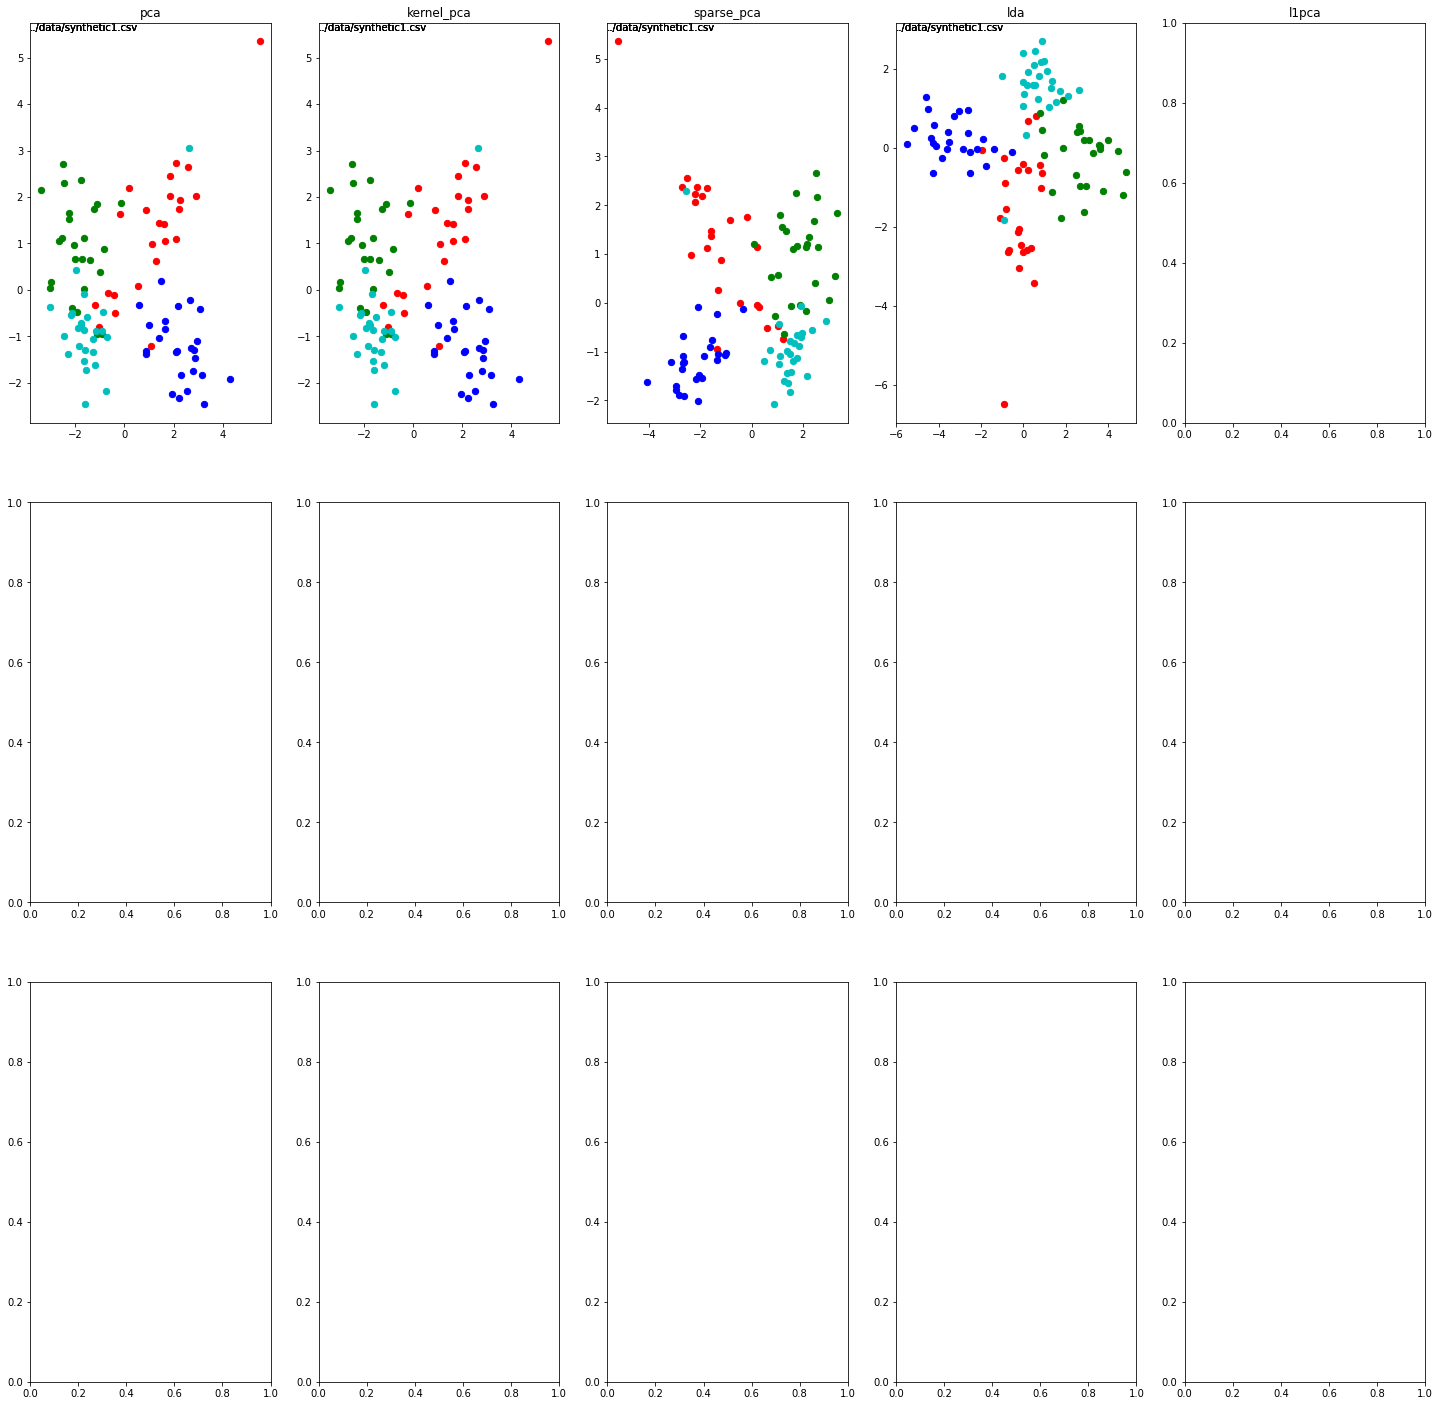

In [89]:
def draw_plots(dimensions):

    if(dimensions==3):
        subplot_kw = dict(projection='3d')
    else:
        subplot_kw = None
    
    fig, axs = plt.subplots(len(dataset_paths), len(methods), subplot_kw=subplot_kw, figsize=(25,25))

    for row, path in enumerate(dataset_paths):
        dataset = pd.read_csv(path)
        targets = dataset[dataset.columns[-1]].unique()
        colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'burlywood', 'chartreuse', 'crimson']

        lda_max_dims = len(targets) - 1

        for column, method in enumerate(methods):
            if row == 0:
                axs[row,column].set_title(method)

            print(f"{method} --- --- --- {path}")

            if method == 'lda':
                df_dims = lda_max_dims
                print("df_dims:", df_dims)
            else:
                df_dims = dimensions

            components = ([f'principal component {i+1}' for i in range(df_dims)])
			
            dataframe = pd.DataFrame(data = methods[method](path, df_dims), columns=components)
            
            for (target, color) in zip(targets,colors):

                plt.text(0, 1, path, ha='left', va='top', transform=axs[row, column].transAxes)

                indicesToKeep = pd.read_csv(path)[dataset.columns[-1]] == target
                if df_dims == 1:
                    x = dataframe.loc[indicesToKeep, 'principal component 1']
                    axs[row, column].scatter(x = x, y = np.zeros_like(x), c = color, s = 40)
                else:
                    axs[row, column].scatter(x = dataframe.loc[indicesToKeep, 'principal component 1'], y = dataframe.loc[indicesToKeep, 'principal component 2'], c = color, s = 40)
                # elif df_dims == 3:
                #     axs[row, column].scatter(xs = dataframe.loc[indicesToKeep, 'principal component 1'], ys = dataframe.loc[indicesToKeep, 'principal component 2'], zs = dataframe.loc[indicesToKeep, 'principal component 3'], c = color, s = 40)
    
    ax_args = {chr(ord('x')+i) + 'label' : 'Principal Component ' + str(i+1) for i in range(0, dimensions)}
    for ax in axs.flat:
        ax.set(**ax_args)

draw_plots(2)

In [ ]:
n_datasets = len(dataset_paths)
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)

scores = np.zeros((len(methods), n_datasets, n_splits))

In [ ]:
def calculate_scores(dataset_paths, classifier, reduce_dimensions=True, f_ratio=None):
	folder_location = '../scores/'
	filename = f"raw_{classifier}" if not reduce_dimensions else f"{str(int(f_ratio*100))}_{classifier}"
	save_path = folder_location+filename

	for data_id, dataset in enumerate(dataset_paths):
		for method_id, method in enumerate(methods):
			data = pd.read_csv(dataset).to_numpy()
			#n_components cannot be larger than min(n_features, n_classes - 1).
			if reduce_dimensions:
				n_features = data.shape[1]
				n_classes = np.unique(data[:,-1]).size
				n_components = int(f_ratio*n_features)
				if method == 'lda' and n_components > min(n_features, n_classes-1):
					n_components = min(n_features, n_classes - 1)
				if n_components < 1:
					n_components = 1
				X=methods[method](dataset, n_components)
				y=getLabels(dataset)
			else:
				X = data[:, :-1]
				y = data[:, -1].astype(int)
			for fold_id, (train, test) in enumerate(skf.split(X, y)):
				clf = clone(clfs[classifier])
				clf.fit(X[train], y[train])
				y_pred = clf.predict(X[test])
				scores[method_id, data_id, fold_id] = accuracy_score(y[test], y_pred)
				
	np.save(save_path, scores)

In [ ]:
# original scores; no dimensionality reduction
for classifier in clfs:
    calculate_scores(dataset_paths=dataset_paths, classifier=classifier, reduce_dimensions=False)
    calculate_scores(dataset_paths=dataset_paths, classifier=classifier, f_ratio=0.25)
    calculate_scores(dataset_paths=dataset_paths, classifier=classifier, f_ratio=0.50)
    calculate_scores(dataset_paths=dataset_paths, classifier=classifier, f_ratio=0.75)

INFORMATION LOSS:		0.449
INFORMATION LOSS:		0.275
INFORMATION LOSS:		0.162
INFORMATION LOSS:		0.184
INFORMATION LOSS:		0.0582
INFORMATION LOSS:		3.75e-13
INFORMATION LOSS:		0.0199
INFORMATION LOSS:		1.69e-13
INFORMATION LOSS:		2.44e-14
INFORMATION LOSS:		0.449
INFORMATION LOSS:		0.275
INFORMATION LOSS:		0.162
INFORMATION LOSS:		0.184
INFORMATION LOSS:		0.0582
INFORMATION LOSS:		3.75e-13
INFORMATION LOSS:		0.0199
INFORMATION LOSS:		1.69e-13
INFORMATION LOSS:		2.44e-14
INFORMATION LOSS:		0.449
INFORMATION LOSS:		0.275
INFORMATION LOSS:		0.162
INFORMATION LOSS:		0.184
INFORMATION LOSS:		0.0582
INFORMATION LOSS:		3.75e-13
INFORMATION LOSS:		0.0199
INFORMATION LOSS:		1.69e-13
INFORMATION LOSS:		2.44e-14
INFORMATION LOSS:		0.449
INFORMATION LOSS:		0.275
INFORMATION LOSS:		0.162
INFORMATION LOSS:		0.184
INFORMATION LOSS:		0.0582
INFORMATION LOSS:		3.75e-13
INFORMATION LOSS:		0.0199
INFORMATION LOSS:		1.69e-13
INFORMATION LOSS:		2.44e-14


In [ ]:
# Scores ma wymiary (metody, zbiory danych, foldy)
scores = np.load('../scores/75_kNN.npy')
print("\nScores:\n", scores.shape)
mean_scores = np.mean(scores, axis=2).T
print("\nMean scores:\n", mean_scores)


Scores:
 (4, 3, 5)

Mean scores:
 [[0.74 0.74 0.78 0.87]
 [0.38 0.38 0.36 0.63]
 [0.94 0.94 0.94 0.99]]


In [ ]:
from scipy.stats import rankdata
ranks = []
for ms in mean_scores:
    ranks.append(rankdata(ms).tolist())
ranks = np.array(ranks)
print(f"Ranks:\n{ranks}")
mean_ranks = np.mean(ranks, axis=0)
print(f"\nMethods:\t\t{[i for i in methods]}")
print(f"Mean ranks:\t{mean_ranks}\n")

Ranks:
[[1.5 1.5 3.  4. ]
 [2.5 2.5 1.  4. ]
 [2.  2.  2.  4. ]]

Methods:		['pca', 'kernel_pca', 'sparse_pca', 'lda']
Mean ranks:	[2. 2. 2. 4.]



In [ ]:
from scipy.stats import ttest_rel

alfa = .05
t_statistic = np.zeros((len(methods), len(methods)))
p_value = np.zeros((len(methods), len(methods)))

for i in range(len(methods)):
    for j in range(len(methods)):
        t_statistic[i, j], p_value[i, j] = ttest_rel(ranks.T[i], ranks.T[j])

In [ ]:
from tabulate import tabulate

headers = list(methods.keys())
names_column = np.expand_dims(np.array(list(methods.keys())), axis=1)
t_statistic_table = np.concatenate((names_column, t_statistic), axis=1)
t_statistic_table = tabulate(t_statistic_table, headers, floatfmt=".2f")
p_value_table = np.concatenate((names_column, p_value), axis=1)
p_value_table = tabulate(p_value_table, headers, floatfmt=".2f")
print("\nt-statistic:\n", t_statistic_table, "\n\np-value:\n", p_value_table)


t-statistic:
                pca    kernel_pca    sparse_pca     lda
----------  ------  ------------  ------------  ------
pca         nan           nan             0.00   -6.93
kernel_pca  nan           nan             0.00   -6.93
sparse_pca    0.00          0.00        nan      -3.46
lda           6.93          6.93          3.46  nan 

p-value:
                pca    kernel_pca    sparse_pca     lda
----------  ------  ------------  ------------  ------
pca         nan           nan             1.00    0.02
kernel_pca  nan           nan             1.00    0.02
sparse_pca    1.00          1.00        nan       0.07
lda           0.02          0.02          0.07  nan


In [ ]:
advantage = np.zeros((len(methods), len(methods)))
advantage[t_statistic > 0] = 1
advantage_table = tabulate(np.concatenate(
    (names_column, advantage), axis=1), headers)
print("\nAdvantage:\n", advantage_table)


Advantage:
               pca    kernel_pca    sparse_pca    lda
----------  -----  ------------  ------------  -----
pca             0             0             0      0
kernel_pca      0             0             0      0
sparse_pca      0             0             0      0
lda             1             1             1      0


In [ ]:
significance = np.zeros((len(methods), len(methods)))
significance[p_value <= alfa] = 1
significance_table = tabulate(np.concatenate(
    (names_column, significance), axis=1), headers)
print("\nStatistical significance (alpha = 0.05):\n", significance_table)


Statistical significance (alpha = 0.05):
               pca    kernel_pca    sparse_pca    lda
----------  -----  ------------  ------------  -----
pca             0             0             0      1
kernel_pca      0             0             0      1
sparse_pca      0             0             0      0
lda             1             1             0      0


In [ ]:
stat_better = significance * advantage
stat_better_table = tabulate(np.concatenate(
    (names_column, stat_better), axis=1), headers)
print("Statistically significantly better:\n", stat_better_table)

Statistically significantly better:
               pca    kernel_pca    sparse_pca    lda
----------  -----  ------------  ------------  -----
pca             0             0             0      0
kernel_pca      0             0             0      0
sparse_pca      0             0             0      0
lda             1             1             0      0
